# Social media sentiment analysis: Use natural language processing techniques to analyze social media posts and identify trends in public opinion on a particular topic.

In [17]:
import re
import nltk
import string
import spacy

import numpy as np 
import pandas as pd
from spacy import displacy

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.metrics import Precision, Recall
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.layers import Attention
from keras.layers import Concatenate, Dense, Input
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from keras import Model
from keras.layers import Layer
from keras.utils import plot_model

import keras.backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import keras


nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
    

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


## Twitter covid-19-nlp-text-classification dataset

In [18]:
twitter_training = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin1')
twitter_training["Sentiment"].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

#### Merging similar sentiments

In [19]:
twitter_training['Sentiment'] = twitter_training['Sentiment'].map({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative',
    'Positive': 'Positive',
    'Negative': 'Negative',
    'Neutral': 'Neutral'
})
twitter_training["Sentiment"].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [20]:
twitter_original = twitter_training.copy()
twitter_training.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   Neutral  
1  advice Talk to your neighbours family to excha...  Positive  
2  Coronavirus Australia: Woolworths to give elde...  Positive  
3  My food stock is not the only one which is emp...  Positive  
4  Me, ready to go at supermarket during the #COV...  Negative  
5  As news of the regionÂs first confirmed COVID...  Positive  
6  Cashier at grocery store was sharing his insig...  Positive  
7  Was at the supermarket today. Didn't buy toile...   Neutral  
8  Due to COVID-19 our retail store and classroom...  Positive  
9  For corona prevention,we should stop to buy th...  Negative

In [21]:
sample_original = twitter_original["OriginalTweet"][1]
sample_original

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

<AxesSubplot:title={'center':'Number for each sentiment in Twitter dataset'}>

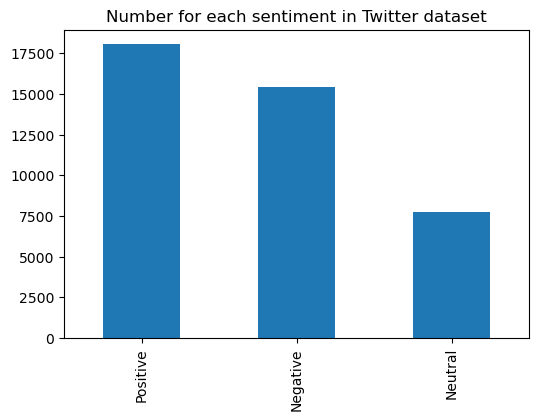

In [22]:
twitter_training["Sentiment"].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Number for each sentiment in Twitter dataset")

<AxesSubplot:title={'center':'Number for each tweet per date'}>

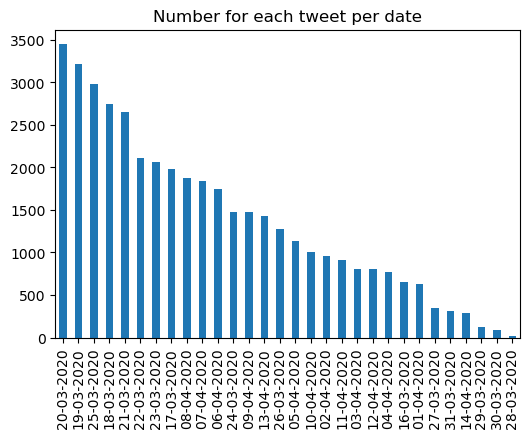

In [23]:
twitter_training["TweetAt"].value_counts().plot(kind='bar',
                                    figsize=(6,4),
                                    title="Number for each tweet per date")

## Data preprocessing

In [24]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove special char
    text = re.sub(r'<.*?>', '', text) # Remove html tags
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Process the text using spaCy
    doc = nlp(text)
    # Extract lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    
    text = ' '.join(lemmatized_tokens)
    
    return text

twitter_training['OriginalTweet'] = twitter_training['OriginalTweet'].astype(str)
twitter_training['OriginalTweet'] = twitter_training['OriginalTweet'].apply(normalize_text)

In [25]:
twitter_training.head(10)

UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet Sentiment  
0  menyrbie philgahan chrisitv httpstcoifzfanpa a...   Neutral  
1  advice talk to your neighbour family to exchan...  Positive  
2  coronavirus australia woolworth to give elderl...  Positive  
3  my food stock be not the only one which be emp...  Positive  
4  I ready to go at supermarket during the covid ...  Negative  
5  as news of the regionâs first confirm covid ca...  Positive  
6  cashier at grocery store be share his insight ...  Positive  
7  be at the supermarket today do not buy toilet ...   Neutral  
8  due to covid our retail store and classroom in...  Positive  
9  for corona preventionwe should stop to buy thi...  Negative

## Sentiments word clouds

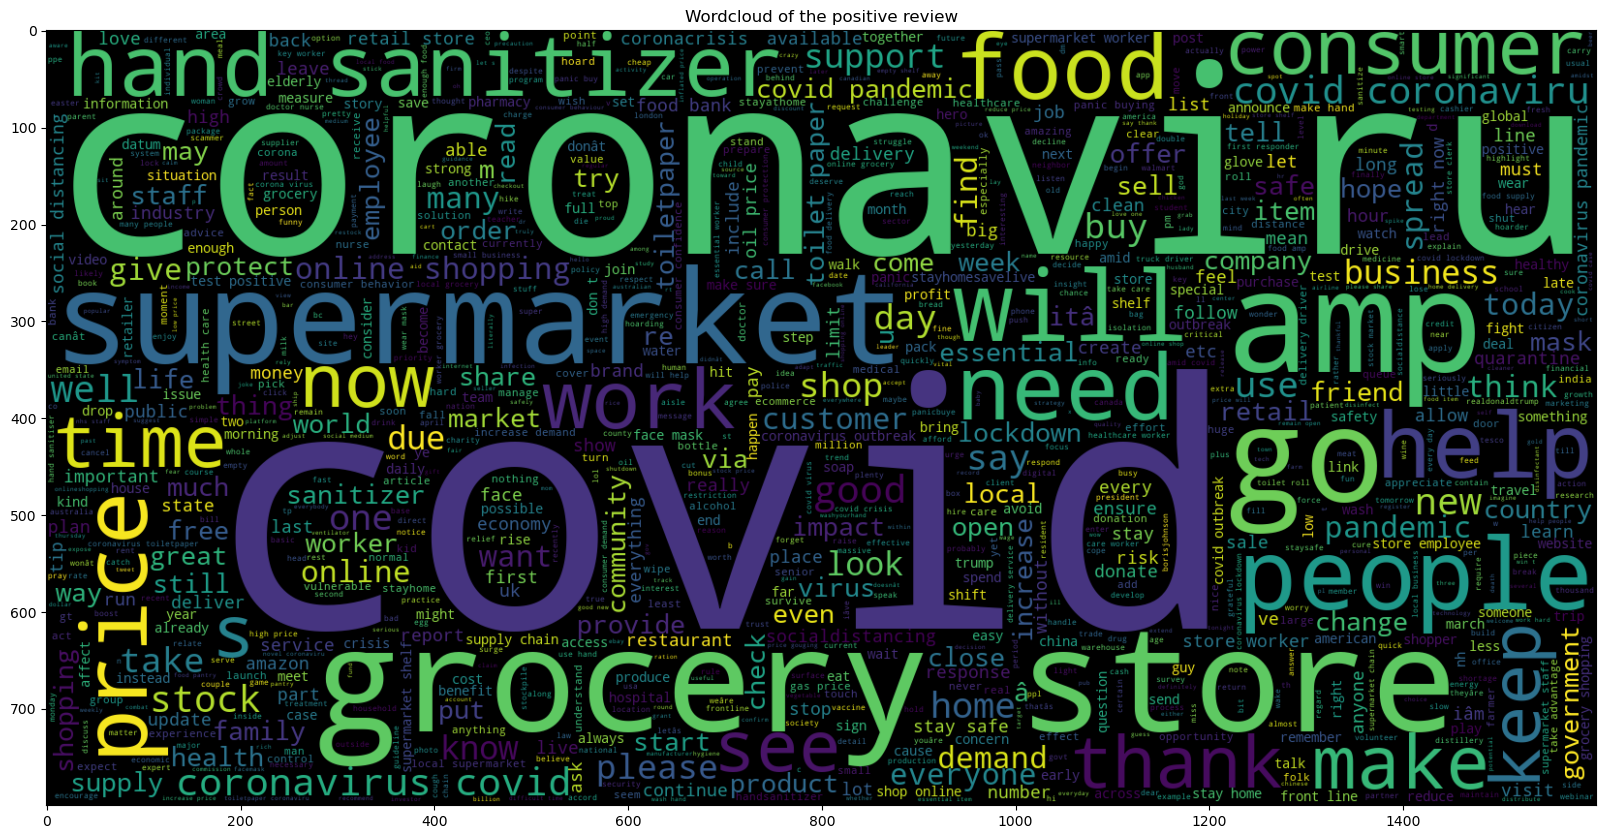

In [26]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["Sentiment"] == "Positive"]["OriginalTweet"]))
plt.title("Wordcloud of the positive review")
plt.imshow(wc, interpolation = 'bilinear')

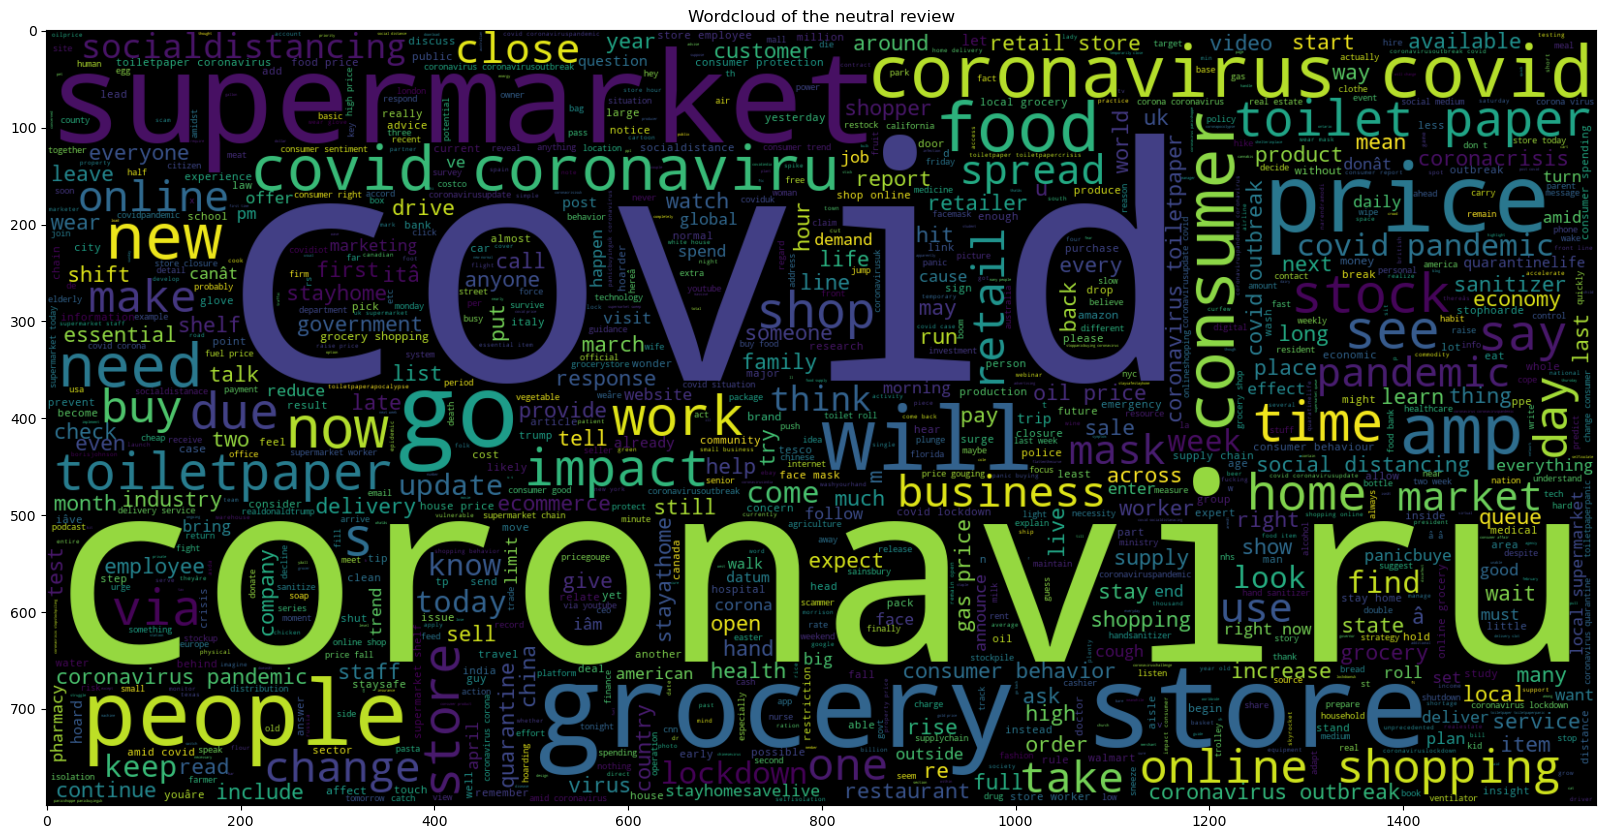

In [27]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["Sentiment"] == "Neutral"]["OriginalTweet"]))
plt.title("Wordcloud of the neutral review")
plt.imshow(wc, interpolation = 'bilinear')

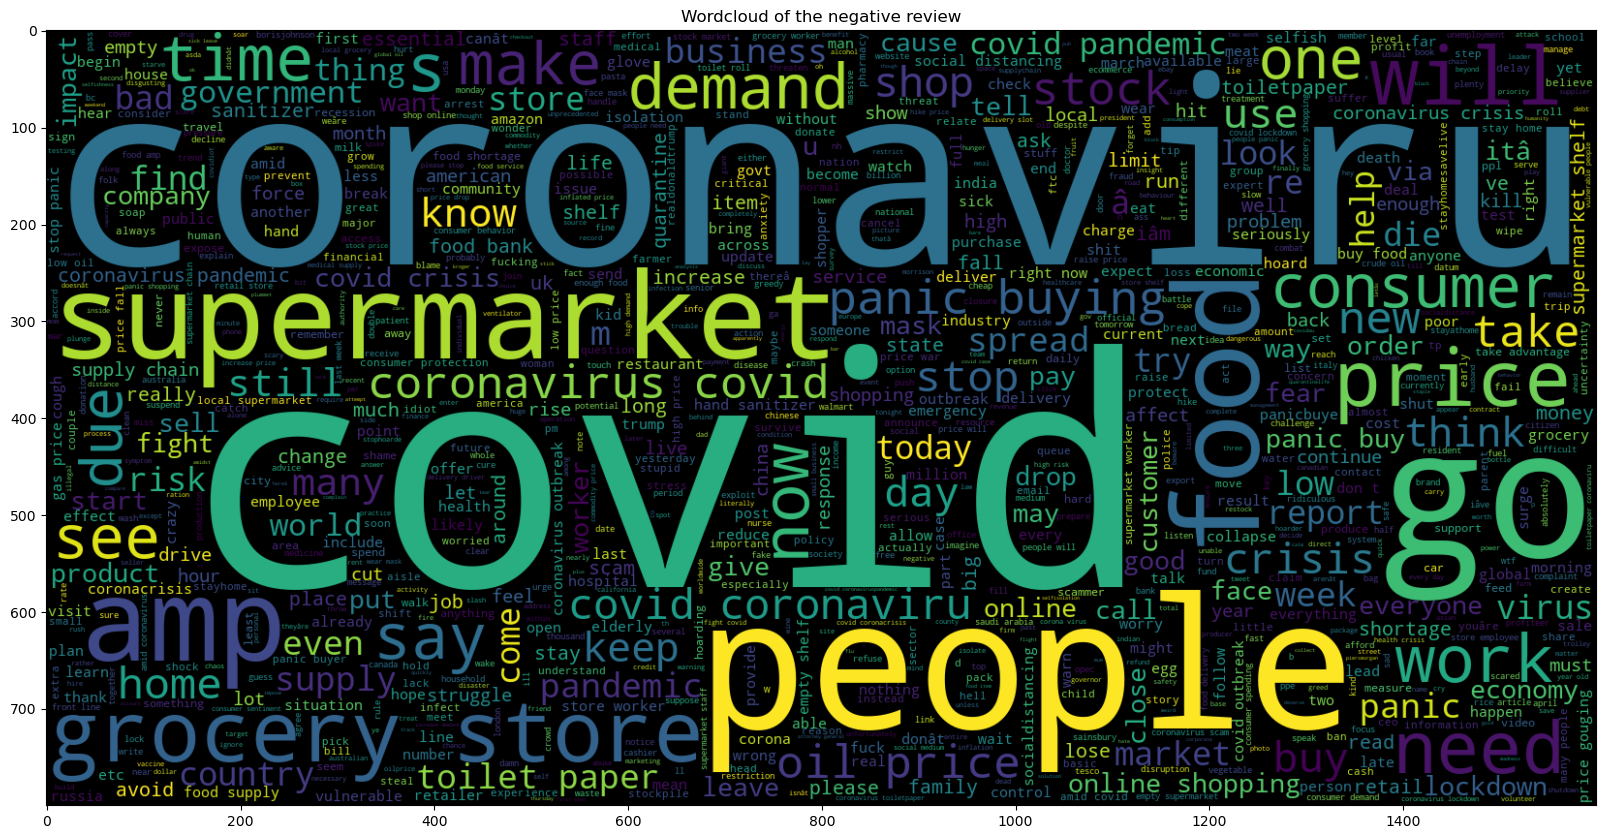

In [28]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words=1000 , width=1600 , height=800).generate(" ".join(twitter_training[twitter_training["Sentiment"] == "Negative"]["OriginalTweet"]))
plt.title("Wordcloud of the negative review")
plt.imshow(wc, interpolation = 'bilinear')

## Tokenization

In [29]:
def fit_transform(tokenizer, text):
    return pad_sequences(tokenizer.texts_to_sequences(text), padding='post', maxlen=max_len)


max_len, max_features = 628, 1000
tokenizer_keras = Tokenizer(num_words=max_features, split=" ", oov_token = True)
tokenizer_keras.fit_on_texts(twitter_training["OriginalTweet"])
X_train = fit_transform(tokenizer_keras, twitter_training["OriginalTweet"])

In [30]:
one_hot = OneHotEncoder(sparse=False)
one_hot.fit(twitter_training[["Sentiment"]])
y_one_hot_train = one_hot.transform(twitter_training[["Sentiment"]])

## The NLP Model - Sentiment Analysis


In [31]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
def lstm_model(input_len, max_features=10000, embed_size=128):
    input_layer = Input(shape=(input_len,), dtype="int32")
    embedded_layer = Embedding(max_features, embed_size)(input_layer)
    lstm_layer = Bidirectional(LSTM(64, return_sequences = True))(embedded_layer)
    attention_layer = attention()(lstm_layer)
    output_layer = Dense(3, activation='softmax')(attention_layer)
    
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3),
                  metrics=['accuracy'])
    return model

In [32]:
model = lstm_model(input_len=628, max_features=1000, embed_size=32)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 628)]             0         
                                                                 
 embedding (Embedding)       (None, 628, 32)           32000     
                                                                 
 bidirectional (Bidirectiona  (None, 628, 128)         49664     
 l)                                                              
                                                                 
 attention (attention)       (None, 128)               756       
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 82,807
Trainable params: 82,807
Non-trainable params: 0
_________________________________________________________

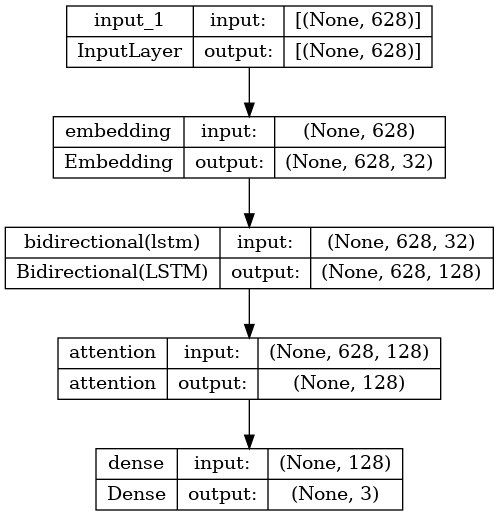

In [33]:
plot_model(model, to_file="model.png", show_shapes=True)

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001)

In [35]:
history = model.fit(X_train, y_one_hot_train, epochs=30, batch_size=64, validation_split=0.2,
                                      verbose=1, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
515/515 [==============================] - 47s 79ms/step - loss: 0.9669 - accuracy: 0.5053 - val_loss: 0.7731 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 2/30
515/515 [==============================] - 40s 77ms/step - loss: 0.6675 - accuracy: 0.7336 - val_loss: 0.6152 - val_accuracy: 0.7529 - lr: 0.0010
Epoch 3/30
515/515 [==============================] - 40s 77ms/step - loss: 0.6015 - accuracy: 0.7691 - val_loss: 0.5953 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 4/30
515/515 [==============================] - 40s 77ms/step - loss: 0.5886 - accuracy: 0.7749 - val_loss: 0.5982 - val_accuracy: 0.7653 - lr: 0.0010
Epoch 5/30
515/515 [==============================] - 40s 77ms/step - loss: 0.5809 - accuracy: 0.7772 - val_loss: 0.5933 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 6/30
515/515 [==============================] - 40s 77ms/step - loss: 0.5714 - accuracy: 0.7811 - val_loss: 0.5937 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 7/30
515/515 [==============================] - 40s 

<Figure size 640x480 with 0 Axes>

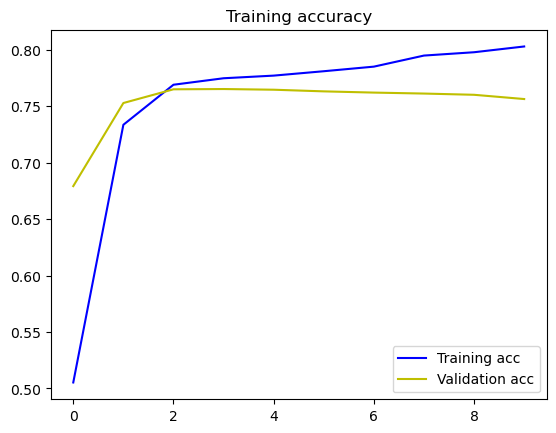

<Figure size 640x480 with 0 Axes>

In [36]:
history_ = history.history
train_acc, train_loss = history_["accuracy"], history_["loss"]
val_acc, val_loss = history_["val_accuracy"], history_["val_loss"]
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'y', label="Validation acc")
plt.title('Training accuracy')
plt.legend()
 
plt.figure()

<Figure size 640x480 with 0 Axes>

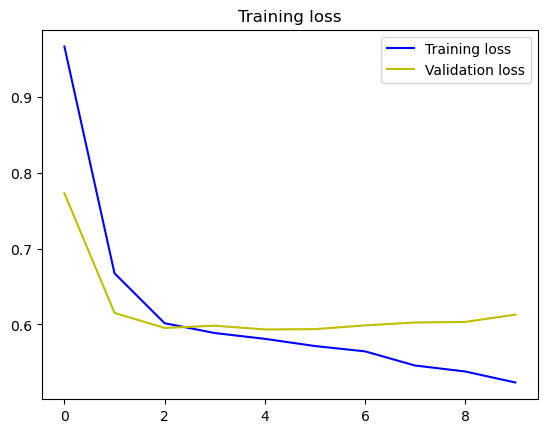

<Figure size 640x480 with 0 Axes>

In [37]:
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label="Validation loss")
plt.title('Training loss')
plt.legend()
 
plt.figure()

In [38]:
def get_predict(model, tokenizer, sample):
    m_proba = model.predict(fit_transform(tokenizer, [sample]), verbose=0)
    res_one_hot_vec = tf.one_hot(tf.argmax(m_proba[0]), 3)
    result = one_hot.inverse_transform([res_one_hot_vec])
    return result[0][0]


def get_val_pred(index):
    actual = twitter_original[["Sentiment"]].loc[index]["Sentiment"]
    prediction = f"Predicted: {get_predict(model, tokenizer_keras, twitter_original['OriginalTweet'].loc[index])} -> Real: {actual}"
    return prediction


In [39]:
print(get_val_pred(35))
print(get_val_pred(54))
print(get_val_pred(19))
print(get_val_pred(14))


Predicted: Neutral -> Real: Neutral
Predicted: Positive -> Real: Negative
Predicted: Positive -> Real: Positive
Predicted: Positive -> Real: Positive


## Checking model performance on test data

In [40]:
twitter_test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv")

twitter_test['OriginalTweet'] = twitter_test['OriginalTweet'].astype(str)
twitter_test['OriginalTweet'] = twitter_test['OriginalTweet'].apply(normalize_text)

twitter_test['Sentiment'] = twitter_test['Sentiment'].map({
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative',
    'Positive': 'Positive',
    'Negative': 'Negative',
    'Neutral': 'Neutral'
})
y_test = one_hot.transform(twitter_test[["Sentiment"]])

In [41]:
X_test = fit_transform(tokenizer_keras, twitter_test["OriginalTweet"])

In [42]:
loss_test, accuracy_test = model.evaluate(x=X_test, y=y_test)

119/119 [==============================] - 3s 23ms/step - loss: 0.6423 - accuracy: 0.7425


### Sample sentiment analysis

In [43]:
my_text_sample = "Find out how you can protect yourself and loved ones from coronavirus"
get_predict(model, tokenizer_keras, normalize_text(my_text_sample))

'Positive'

In [44]:
my_text_sample = "Panic food buying in Germany due to #coronavirus has begun."
get_predict(model, tokenizer_keras, normalize_text(my_text_sample))

'Negative'

# Topic clustering and naming

In [45]:
! pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 58.2 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp37-cp37m-linux_x86_64.whl size=3430471 sha256=58d490949eb568c471886ad5c5397b0da1993d3c70038a39a21591653f0c9411
  Stored in directory: /root/.cache/pip/wheels/e5/7d/a3/71a87d8d1959fe351849defe5b2e7bc51c73915af79ea8bcbd
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d0d40e624f29fcb67172916c07acfb6e1d54cf0c6e96f9d27da1f4f10dfcbffb
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f20b4891240ff60c86f
Successfully

In [46]:
from random import sample

import pandas as pd
import seaborn as sns

from bertopic import BERTopic

from transformers import T5ForConditionalGeneration, T5Tokenizer, pipeline


In [47]:
twitter_lst = twitter_training['OriginalTweet'].to_list()

In [48]:
topic_model = BERTopic(verbose=True, min_topic_size=20)
topics, probs = topic_model.fit_transform(twitter_lst)

2024-03-28 15:45:54,595 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1287 [00:00<?, ?it/s]

2024-03-28 15:46:19,625 - BERTopic - Embedding - Completed ✓
2024-03-28 15:46:19,626 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-28 15:47:10,800 - BERTopic - Dimensionality - Completed ✓
2024-03-28 15:47:10,803 - BERTopic - Cluster - Start clustering the reduced embeddings


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2024-03-28 15:47:15,171 - BERTopic - Cluster - Completed ✓
2024-03-28 15:47:15,186 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-28 15:47:18,259 - BERTopic - Representation - Completed ✓


In [49]:
original_text = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin1')

In [50]:
def get_topics_by_id(topic_id):
    indices_topics_by_id = np.argwhere(np.asarray(topics) == topic_id).astype(np.int32).reshape(-1)
    topics_by_id_original = [original_text["OriginalTweet"][i] for i in indices_topics_by_id]
    topics_by_id_preprocessed = [twitter_lst[i] for i in indices_topics_by_id]
    return topics_by_id_original, topics_by_id_preprocessed

In [51]:
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-base")
language_model = T5ForConditionalGeneration.from_pretrained("t5-base")
headline_generator = T5ForConditionalGeneration.from_pretrained("Michau/t5-base-en-generate-headline")

summarizer = pipeline("summarization", model=language_model, tokenizer=tokenizer_t5, framework="tf")


In [52]:
def generate_topic_label(articles: list) -> str:
    summary_list = []
    current_token_length = 0
    max_token_length = 512
    
    for article in sample(articles, k=len(articles)):
        summary = summarizer(article)[0]["summary_text"]
        current_token_length += len(tokenizer_t5.encode(summary))
        if current_token_length >= max_token_length:
            break
        summary_list.append(summary)

    encoding = tokenizer_t5.encode("headline: " + " ".join(summary_list), return_tensors="pt")
    output = headline_generator.generate(encoding)
    
    return tokenizer_t5.decode(output[0][1:-1])


In [53]:
def analyze_topic_sentiment(tweets_preprocessed):
    list_semantics = []
    for tweet in tweets_preprocessed:
        list_semantics.append(get_predict(model, tokenizer_keras, tweet))
    return list_semantics

In [54]:
list_analysis = []
for i in range(15):
    topics_by_id_original, topics_by_id_preprocessed = get_topics_by_id(i)
    title = generate_topic_label(topics_by_id_original)
    output_predictions = model.predict(fit_transform(tokenizer_keras, topics_by_id_preprocessed), verbose=0)
    print(title)
    res_one_hot_vec = one_hot.inverse_transform(output_predictions)
    unique, counts = np.unique(res_one_hot_vec, return_counts=True)
    print(np.asarray((unique, counts)).T)
    
    list_analysis.append((title, unique, counts))
    
    print('*******************')

    

Your max_length is set to 200, but you input_length is only 140. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)
Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 60. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 200, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 200, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 200, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 200, but you input_length is only 103. You might consid

#Coronavirus #ToiletPaperPanic #Corona
[['Negative' 552]
 ['Neutral' 651]
 ['Positive' 646]]
*******************


Your max_length is set to 200, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)
Your max_length is set to 200, but you input_length is only 68. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but you input_length is only 90. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 200, but you input_length is only 79. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 200, but you input_length is only 115. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 200, but you input_length is only 50. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 57. You might consider

Brands Are Finding Success Delivering the Essentials
[['Negative' 250]
 ['Neutral' 363]
 ['Positive' 407]]
*******************


Your max_length is set to 200, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 200, but you input_length is only 64. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 200, but you input_length is only 50. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 79. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 200, but you input_length is only 62. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 82. You might consider

Oil Prices Rise As #Coronavirus Pandemic Awaits
[['Negative' 641]
 ['Neutral' 94]
 ['Positive' 174]]
*******************


Your max_length is set to 200, but you input_length is only 69. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but you input_length is only 50. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 63. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 200, but you input_length is only 107. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 200, but you input_length is only 121. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Your max_length is set to 200, but you input_length is only 105. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=52)
Your max_length is set to 200, but you input_length is only 54. You might consi

COVID-19 - Price Gouging
[['Negative' 340]
 ['Neutral' 125]
 ['Positive' 317]]
*******************


Your max_length is set to 200, but you input_length is only 79. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 200, but you input_length is only 107. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 200, but you input_length is only 42. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 200, but you input_length is only 79. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 200, but you input_length is only 77. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 200, but you input_length is only 75. You might conside

Consumer Law Developments Affect Consumers amp Healthcare Industries
[['Negative' 272]
 ['Neutral' 71]
 ['Positive' 403]]
*******************


Your max_length is set to 200, but you input_length is only 97. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Your max_length is set to 200, but you input_length is only 84. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 200, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 200, but you input_length is only 21. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 200, but you input_length is only 107. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 200, but you input_length is only 40. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)
Your max_length is set to 200, but you input_length is only 89. You might conside

Coronavirus Scams - What You Need to Know
[['Negative' 449]
 ['Neutral' 33]
 ['Positive' 141]]
*******************


Your max_length is set to 200, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 200, but you input_length is only 69. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but you input_length is only 51. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 200, but you input_length is only 60. You might consider

COVID-19 Demand at Food Banks
[['Negative' 235]
 ['Neutral' 23]
 ['Positive' 346]]
*******************


Your max_length is set to 200, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 200, but you input_length is only 77. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 200, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 200, but you input_length is only 63. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 200, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 64. You might consider

Panic Buying - The Coronavirus Crisis
[['Negative' 414]
 ['Neutral' 5]
 ['Positive' 61]]
*******************


Your max_length is set to 200, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 49. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 200, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 47. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 200, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 200, but you input_length is only 29. You might consider

The New Face Masks - The New Face Masks
[['Negative' 140]
 ['Neutral' 118]
 ['Positive' 222]]
*******************


Your max_length is set to 200, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)
Your max_length is set to 200, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)
Your max_length is set to 200, but you input_length is only 33. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 200, but you input_length is only 49. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 200, but you input_length is only 43. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 42. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
Your max_length is set to 200, but you input_length is only 20. You might consider 

Gas Prices Are Down in Colorado Springs - Gas Prices Are Down in Texas
[['Negative' 182]
 ['Neutral' 97]
 ['Positive' 106]]
*******************


Your max_length is set to 200, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 24. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 200, but you input_length is only 68. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 200, but you input_length is only 79. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Your max_length is set to 200, but you input_length is only 47. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)
Your max_length is set to 200, but you input_length is only 74. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 200, but you input_length is only 30. You might consider

#Coronavirus #Shopping #Groceries
[['Negative' 76]
 ['Neutral' 167]
 ['Positive' 133]]
*******************


Your max_length is set to 200, but you input_length is only 85. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 200, but you input_length is only 59. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 200, but you input_length is only 56. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 67. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=33)
Your max_length is set to 200, but you input_length is only 83. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Your max_length is set to 200, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 200, but you input_length is only 90. You might consider

Ecommerce Sales Continue to Escalate Post COVID-19
[['Negative' 78]
 ['Neutral' 112]
 ['Positive' 171]]
*******************


Your max_length is set to 200, but you input_length is only 62. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 200, but you input_length is only 91. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 200, but you input_length is only 51. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
Your max_length is set to 200, but you input_length is only 57. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 200, but you input_length is only 70. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 200, but you input_length is only 68. You might consider

#CoronaVirus #HandSanitizer #Covid19 #Co
[['Negative' 22]
 ['Neutral' 7]
 ['Positive' 318]]
*******************


Your max_length is set to 200, but you input_length is only 71. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 200, but you input_length is only 61. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 200, but you input_length is only 93. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 200, but you input_length is only 64. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 200, but you input_length is only 99. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 200, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 98. You might consider

Coronavirus Consumer Bailout - How to Protect Your Financials
[['Negative' 99]
 ['Neutral' 45]
 ['Positive' 183]]
*******************


Your max_length is set to 200, but you input_length is only 61. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 200, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 200, but you input_length is only 57. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 200, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 200, but you input_length is only 76. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 200, but you input_length is only 90. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Your max_length is set to 200, but you input_length is only 44. You might consider

The Sideshow - Thank You to Our Everyday Heroes
[['Negative' 20]
 ['Neutral' 11]
 ['Positive' 260]]
*******************


## Separate topic sentiment analysis

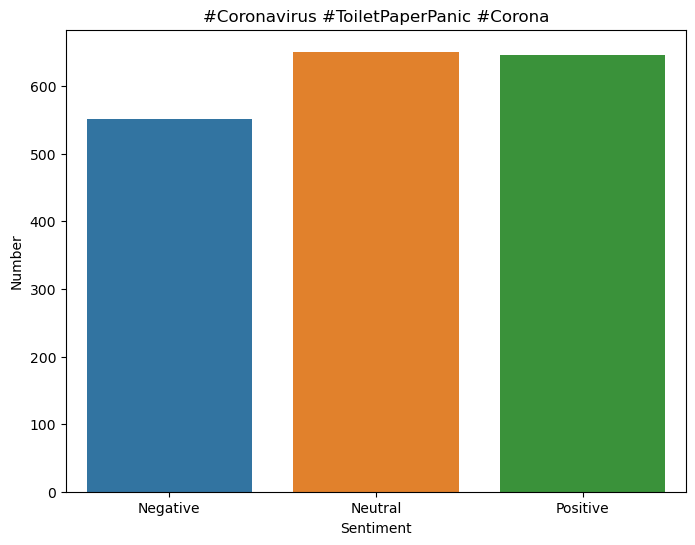

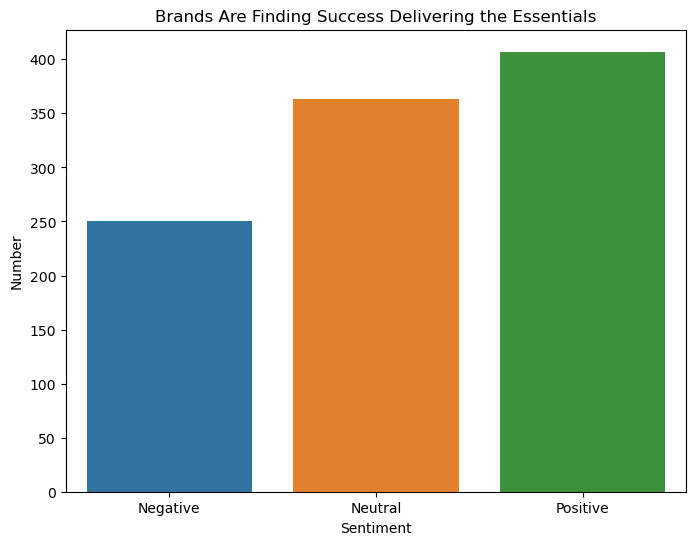

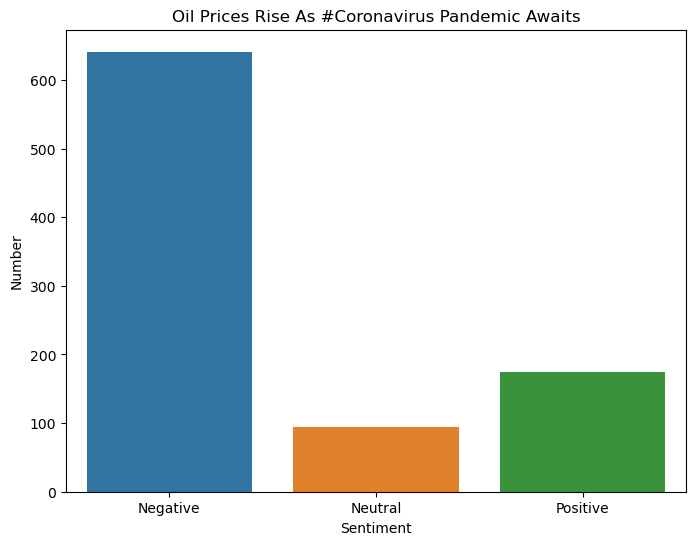

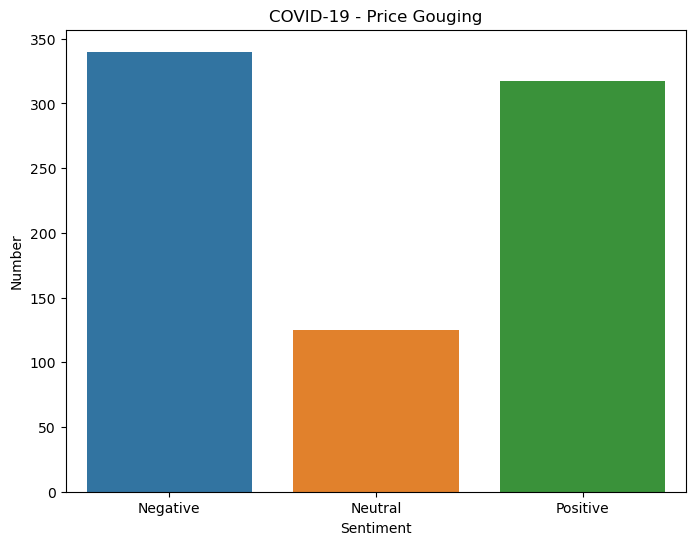

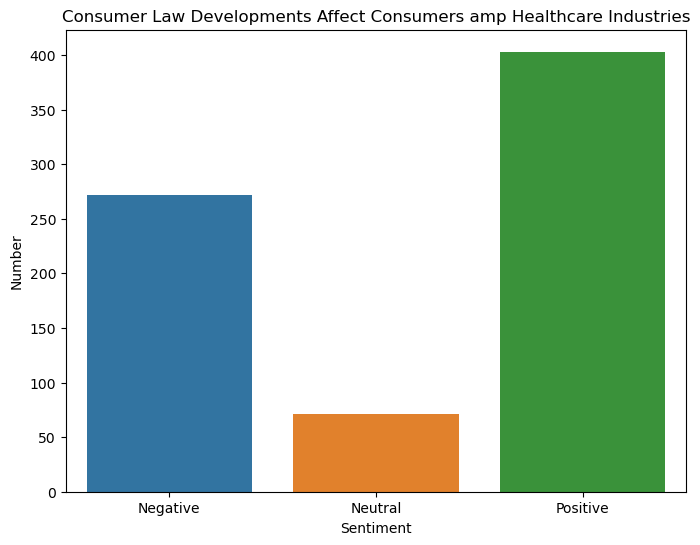

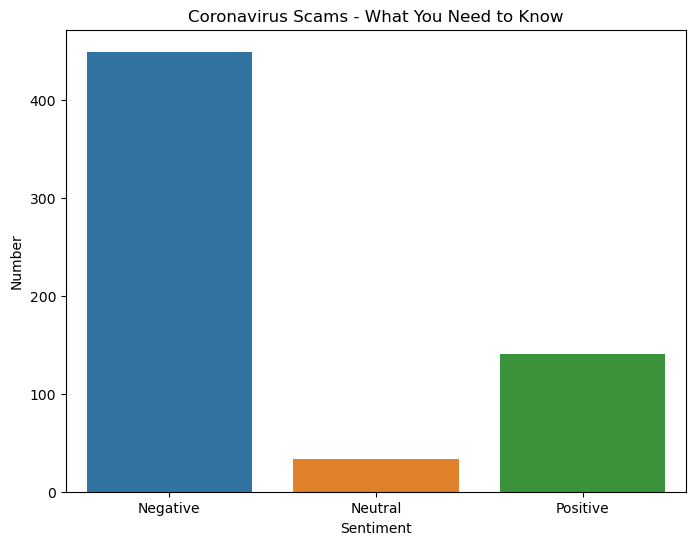

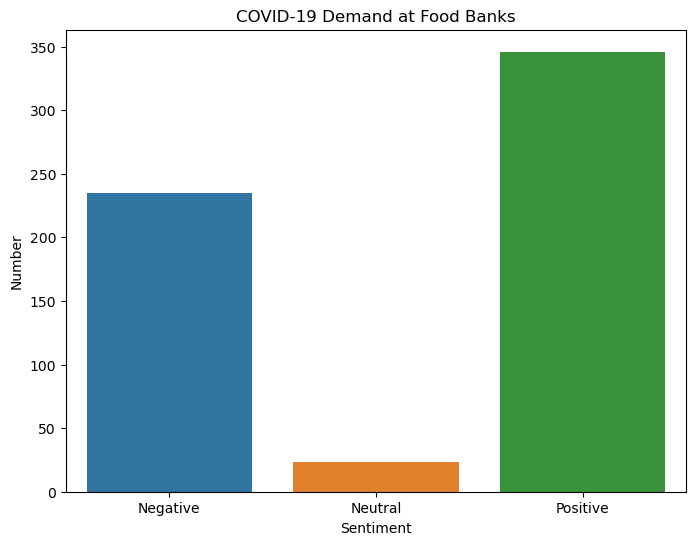

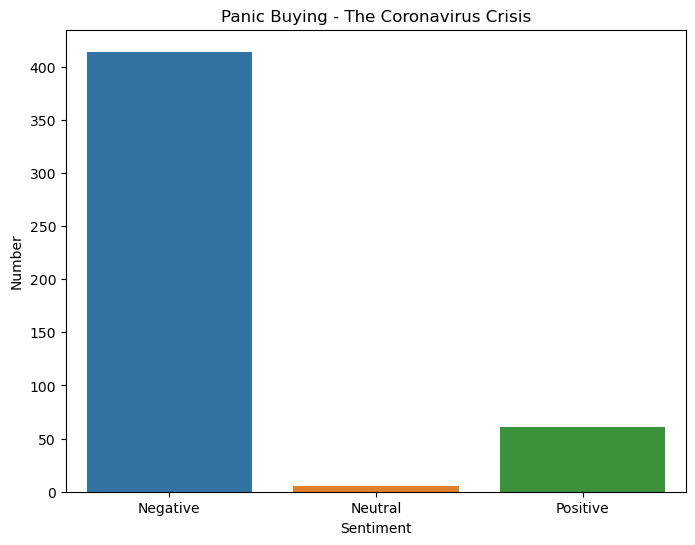

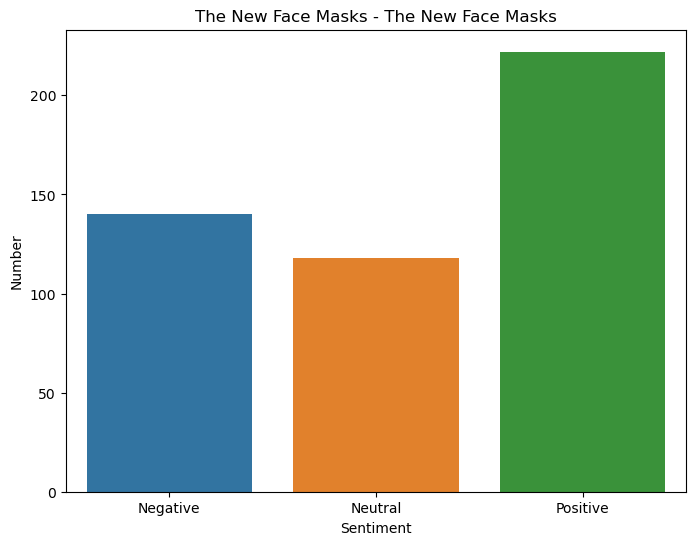

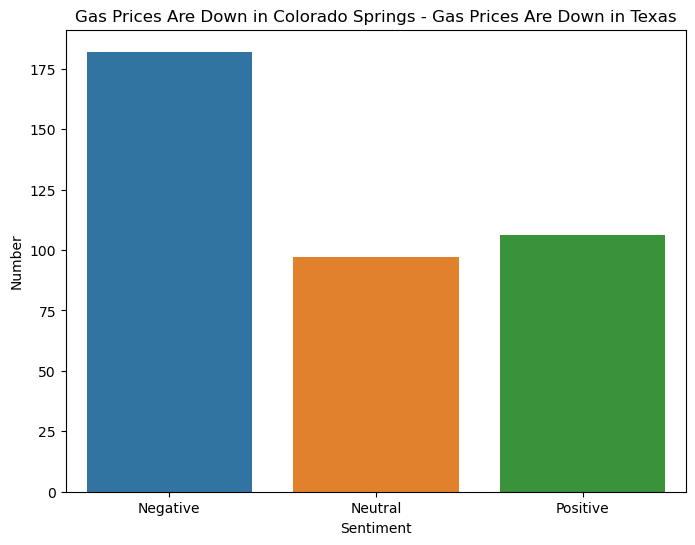

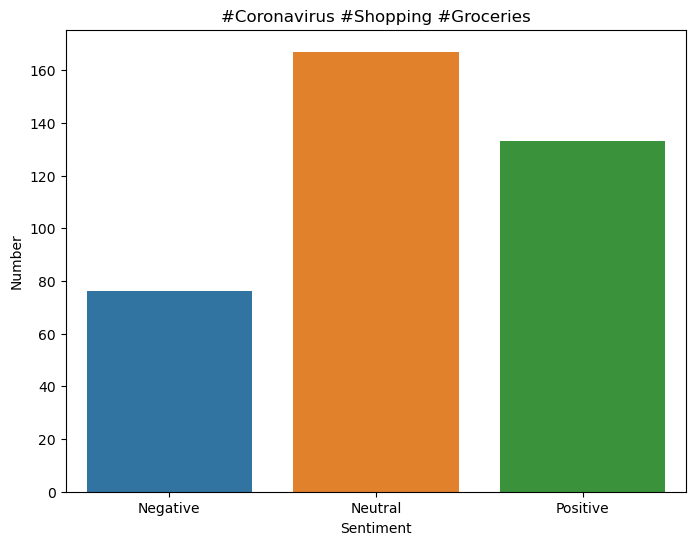

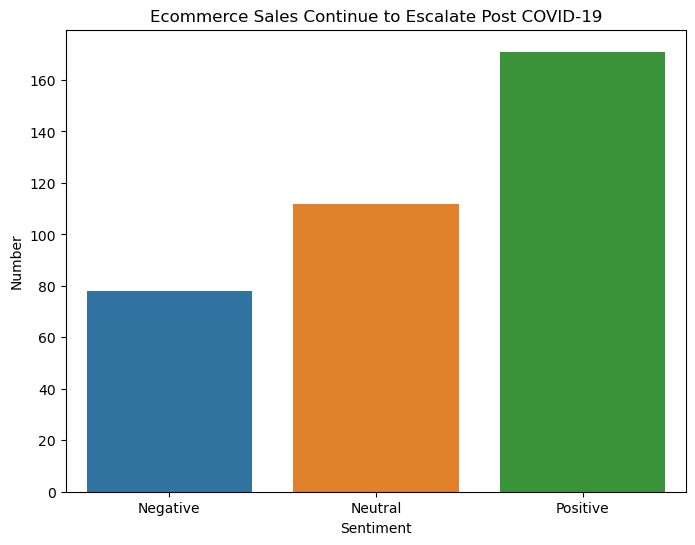

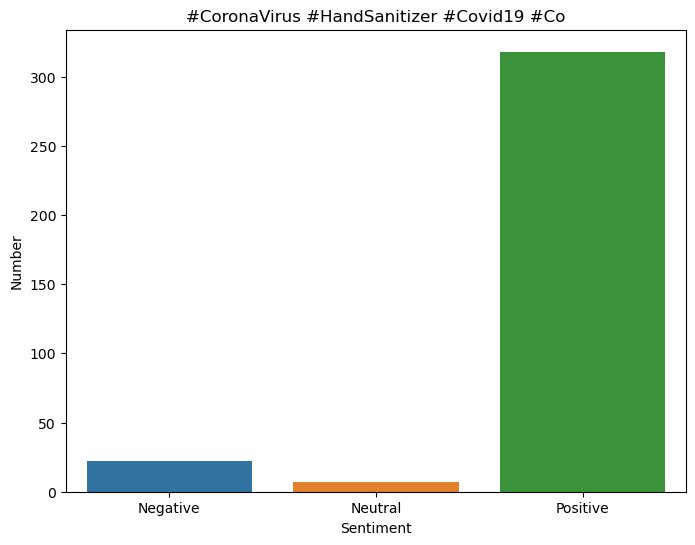

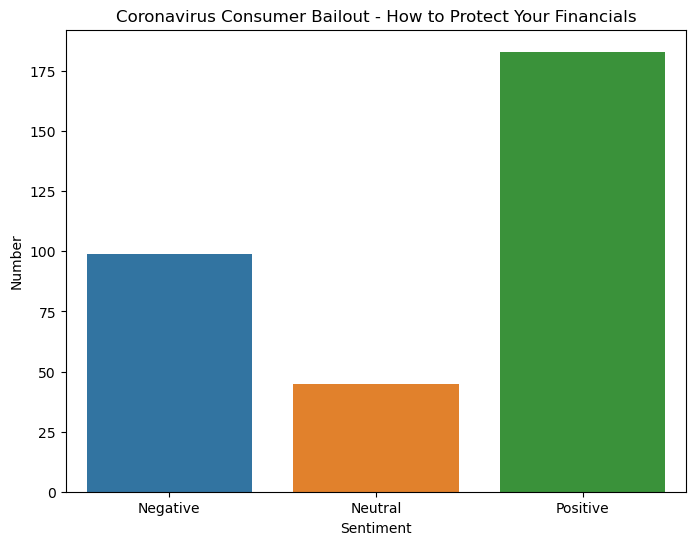

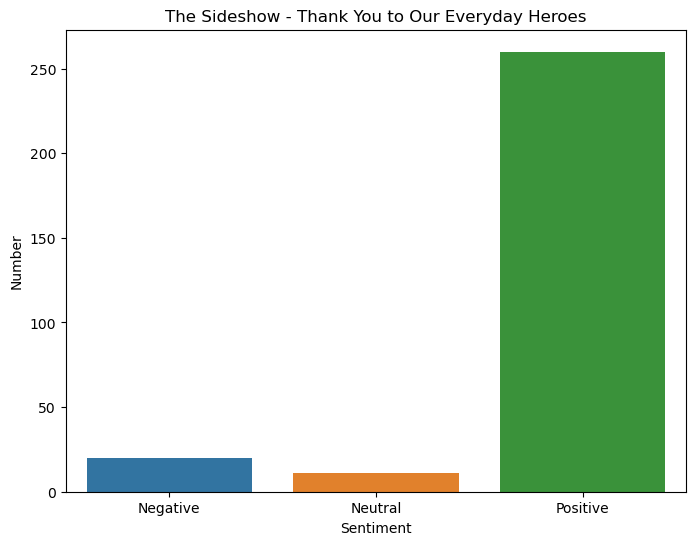

In [55]:
for idx, (topic, sentiment_lst, nums) in enumerate(list_analysis):
    df = pd.DataFrame({"Number":nums, "Sentiment":sentiment_lst})
    plt.figure(idx, figsize=(8, 6))
    plt.title(topic)
    sns.barplot(df, x="Sentiment", y="Number")
plt.show()
